In [1]:
import pandas as pd
import pandas_market_calendars as mcal
import datetime
from Tools.Trade_Functions import *
import numpy as np
import plotly.express as px


In [2]:
cal = get_calendar()

In [3]:
def pick_trade(RunDate,NumStocks,stopLoss=-0.01,holdTime=0,TimeInput=5,debug=False):
    #Calculate pct change
    PctChange = get_SortedPctChange(RunDate,TimeInput,debug=debug)
    
    #select first N stocks and caculate percent retruns
    LongStockList = PctChange["Ticker"].iloc[:NumStocks]
    LongReturns = getLongReturns(RunDate,LongStockList,stopLoss=stopLoss,holdTime=holdTime,debug=debug)
    
    #select bottom N stocks and caculate percent retruns
    ShortStockList = PctChange["Ticker"].iloc[len(PctChange["Ticker"])-NumStocks:]
    ShortReturns = getShortReturns(RunDate,ShortStockList,stopLoss=stopLoss,holdTime=holdTime,debug=debug)
    TotalReturn = sum(LongReturns) / NumStocks + sum(ShortReturns) / NumStocks
   # print(f"Date:{RunDate}, Long Stocks:{list(LongStockList)}, Short Stocks:{list(ShortStockList)}, Return:{TotalReturn}\n")
    return TotalReturn

In [6]:
def calculate_mdd(return_vals):
    # Calculate the cumulative returns (wealth index)
    wealth_index = (1 + return_vals).cumprod()
    
    # Calculate the running maximum
    running_max = wealth_index.cummax()
    
    # Calculate drawdowns (difference between running max and current value)
    drawdowns = (wealth_index - running_max) / running_max
    
    # The maximum drawdown is the largest negative drawdown (i.e., most significant loss)
    mdd = drawdowns.min()  # This will give the maximum drawdown (most negative value)
    
    return mdd

In [7]:
calculate_mdd(returnDf["Return"])

-0.2760494840533315

In [8]:
returnDf["Return"]

0       0.000000
1       0.007031
2       0.004967
3      -0.001485
4      -0.005555
          ...   
2474    0.013958
2475   -0.009792
2476   -0.008344
2477    0.004128
2478   -0.002847
Name: Return, Length: 2479, dtype: float64

In [4]:
TotalReturnList = list()
DateReturnList = list()
TimeInput = 2
NumStocks= 15
holdTime=0


#Anual Range
#year=2019
#yearlyDates = [date for date in cal if date.startswith(str(year))]
#DateRange = [yearlyDates[0], yearlyDates[-1]]

#Set custome Range
DateRange=['2015-01-02','2024-11-07']

DateRange=[cal.index(DateRange[0]),cal.index(DateRange[1])]
for day in cal[DateRange[0]:DateRange[1]]:
    dailyReturn = pick_trade(RunDate=day,NumStocks=NumStocks,TimeInput=TimeInput,holdTime=holdTime,debug=False)
    TotalReturnList.append(dailyReturn)
    

returnDf = pd.DataFrame({'Date': pd.to_datetime(cal[DateRange[0]:DateRange[1]]),'Return':TotalReturnList})


M = 1
returnVal=[]
for i in returnDf["Return"]:
    M = M*(1+i)
    returnVal.append(M)
returnDf=pd.concat([returnDf,pd.DataFrame({"ReturnVals":returnVal})],axis=1)





UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- VEON ----
UNABLE TO FIND:--- BIDU ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- MDLZ ----
UNABLE TO FIND:--- SRCL ----
UNABLE TO FIND:--- TSCO ----
UNABLE TO FIND:--- DISH ----
UNABLE TO FIND:--- AMZN ----
UNABLE TO FIND:--- ALXN ----
UNABLE TO FIND:--- CHRW ----
UNABLE TO FIND:--- GOOG ----
UNABLE TO FIND:--- CHTR ----
UNABLE TO FIND:--- CSCO ----
UNABLE TO FIND:--- INTC ----
UNABLE TO FIND:--- BRCM ----
UNABLE TO FIND:--- MSFT ----
UNABLE TO FIND:--- NVDA ----
UNABLE TO FIND:--- CTSH ----
UNABLE TO FIND:--- ISRG ----
UNABLE TO FIND:--- STX ----
UNABLE TO FIND:--- EBAY ----
UNABLE TO FIND:--- BKNG ----
UNABLE TO FIND:--- ILMN ----
UNABLE TO FIND:--- AKAM ----
UNABLE TO FIND:--- TXN ----
UNABLE TO FIND:--- GOOGL ----
UNABLE TO FIND:--- WDC ----
UNABLE TO FIND:--- NFLX ----
UNABLE TO FIND:--- ADP ----
UNABLE TO FIND:--- GRMN ----
UNABLE TO FIND:--- EQIX ----
UNABLE TO FIND:--- ADBE ----
UNABLE TO FIND:--- AMGN ----
UNABLE TO FIN

UNABLE TO FIND:--- 1448062D ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- CTRX ----
UNABLE TO FIND:--- 1288453D ----
UNABLE TO FIND:--- KRFT ----
UNABLE TO FIND:--- 1448062D ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- CTRX ----
UNABLE TO FIND:--- 1288453D ----
UNABLE TO FIND:--- KRFT ----
UNABLE TO FIND:--- 1448062D ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- CTRX ----
UNABLE TO FIND:--- 1288453D ----
UNABLE TO FIND:--- KRFT ----
UNABLE TO FIND:--- 1448062D ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- CTRX ----
UNABLE TO FIND:--- 1288453D ----
UNABLE TO FIND:--- KRFT ----
UNABLE TO FIND:--- 1448062D ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- CTRX ----
UNABLE TO FIND:--- 1288453D ----
UNABLE TO FIND:--- KRFT ----
UNABLE TO FIND:--- 1448062D ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- CTRX ----
UNABLE TO FIND:--- 1288453D ----
UNABLE TO FIND:--- KRFT ----
UNABLE TO FIND:--- 1448062D ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIN

UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO 

UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- 1396924D ----
UNABLE TO FIND:--- 1396926D ----
UNABLE TO FIND:--- SNDK ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- 1396924D ----
UNABLE TO FIND:--- 1396926D ----
UNABLE TO FIND:--- SNDK ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- 1396924D ----
UNABLE TO FIND:--- 1396926D ----
UNABLE TO FIND:--- SNDK ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- 1396924D ----
UNABLE TO FIND:--- 1396926D ----
UNABLE TO FIND:--- SNDK ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- 1396924D ----
UNABLE TO FIND:--- 1396926D ----
UNABLE TO FIND:--- SNDK ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- 1396924D ----
UNABLE TO FIND:--- 1396926D ----
UNABLE TO FIND:--- SNDK ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- 1396924D ----
UNABLE TO FIND:--- 1396926D ----
UNABLE TO FIND:--- SNDK ----
UNABLE TO FIND:--- BBBYQ ----
UNABLE TO FIND:--- 1396924D ----
UNABLE TO FIND:--- 1396926D ----
UNABLE TO FIND:--- SNDK ----


UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO FIND:--- 1518855D ----
UNABLE TO 

UNABLE TO FIND:--- LVNTA ----
UNABLE TO FIND:--- 9999826D ----
UNABLE TO FIND:--- 9999825D ----
UNABLE TO FIND:--- LVNTA ----
UNABLE TO FIND:--- 9999826D ----
UNABLE TO FIND:--- 9999825D ----
UNABLE TO FIND:--- LVNTA ----
UNABLE TO FIND:--- 9999826D ----
UNABLE TO FIND:--- 9999825D ----
UNABLE TO FIND:--- LVNTA ----
UNABLE TO FIND:--- 9999826D ----
UNABLE TO FIND:--- 9999825D ----
UNABLE TO FIND:--- LVNTA ----
UNABLE TO FIND:--- 9999826D ----
UNABLE TO FIND:--- 9999825D ----
UNABLE TO FIND:--- LVNTA ----
UNABLE TO FIND:--- 9999826D ----
UNABLE TO FIND:--- 9999825D ----
UNABLE TO FIND:--- LVNTA ----
UNABLE TO FIND:--- 9999826D ----
UNABLE TO FIND:--- 9999825D ----
UNABLE TO FIND:--- LVNTA ----
UNABLE TO FIND:--- 9999826D ----
UNABLE TO FIND:--- 9999825D ----
UNABLE TO FIND:--- LVNTA ----
UNABLE TO FIND:--- 9999826D ----
UNABLE TO FIND:--- 9999825D ----
UNABLE TO FIND:--- LVNTA ----
UNABLE TO FIND:--- 9999826D ----
UNABLE TO FIND:--- 9999825D ----
UNABLE TO FIND:--- LVNTA ----
UNABLE TO 

UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA --

UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA ----
UNABLE TO FIND:--- TFCF ----
UNABLE TO FIND:--- TFCFA --

UNABLE TO FIND:--- ABNB ----
UNABLE TO FIND:--- AEP ----
UNABLE TO FIND:--- APP ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- AZN ----
UNABLE TO FIND:--- BKR ----
UNABLE TO FIND:--- CCEP ----
UNABLE TO FIND:--- CEG ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- GEHC ----
UNABLE TO FIND:--- GFS ----
UNABLE TO FIND:--- HON ----
UNABLE TO FIND:--- KDP ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- PANW ----
UNABLE TO FIND:--- ROP ----
UNABLE TO FIND:--- WBD ----
UNABLE TO FIND:--- ABNB ----
UNABLE TO FIND:--- AEP ----
UNABLE TO FIND:--- APP ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- AZN ----
UNABLE TO FIND:--- BKR ----
UNABLE TO FIND:--- CCEP ----
UNABLE TO FIND:--- CEG ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- GEHC ----
UNABLE TO FIND:--- GFS ----
UNABLE TO FIND:--- HON ----
UNABLE TO FIND:--- KDP ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- PANW ----
UNABLE TO FIND:--- ROP ----
UNABLE TO FIND:--- WBD ----
UNABLE TO FIND:--- ABNB ----
UNABLE TO

UNABLE TO FIND:--- APP ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- BKR ----
UNABLE TO FIND:--- CCEP ----
UNABLE TO FIND:--- CEG ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- GEHC ----
UNABLE TO FIND:--- GFS ----
UNABLE TO FIND:--- HON ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- PANW ----
UNABLE TO FIND:--- ROP ----
UNABLE TO FIND:--- WBD ----
UNABLE TO FIND:--- APP ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- BKR ----
UNABLE TO FIND:--- CCEP ----
UNABLE TO FIND:--- CEG ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- GEHC ----
UNABLE TO FIND:--- GFS ----
UNABLE TO FIND:--- HON ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- PANW ----
UNABLE TO FIND:--- ROP ----
UNABLE TO FIND:--- WBD ----
UNABLE TO FIND:--- APP ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- BKR ----
UNABLE TO FIND:--- CCEP ----
UNABLE TO FIND:--- CEG ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- GEHC ----
UNABLE TO FIND:--- GFS ----
UNABLE TO FIND:--- HON ----
UNABLE TO

UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- BKR ----
UNABLE TO FIND:--- CCEP ----
UNABLE TO FIND:--- CEG ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- GEHC ----
UNABLE TO FIND:--- GFS ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- PANW ----
UNABLE TO FIND:--- ROP ----
UNABLE TO FIND:--- WBD ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- BKR ----
UNABLE TO FIND:--- CCEP ----
UNABLE TO FIND:--- CEG ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- GEHC ----
UNABLE TO FIND:--- GFS ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- PANW ----
UNABLE TO FIND:--- ROP ----
UNABLE TO FIND:--- WBD ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- BKR ----
UNABLE TO FIND:--- CCEP ----
UNABLE TO FIND:--- CEG ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- GEHC ----
UNABLE TO FIND:--- GFS ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- PANW ----
UNABLE TO FIND:--- ROP ----
UNABLE TO FIND:--- WBD ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- BKR ----
UNABLE T

UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- GEHC ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- ROP ----
UNABLE TO FIND:--- WBD ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- GEHC ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- ROP ----
UNABLE TO FIND:--- WBD ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- GEHC ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- ROP ----
UNABLE TO FIND:--- WBD ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- GEHC ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- ROP ----
UNABLE TO FIND:--- WBD ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- GEHC ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- ROP ----
UNABLE TO FIND:--- WBD ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- GEHC ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- ROP ----
UNABLE T

UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- GEHC ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- ROP ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- GEHC ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- ROP ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- GEHC ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- ROP ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- GEHC ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- ROP ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- GEHC ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- ROP ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- GEHC ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- ROP ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- GEHC ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- ROP ----
UNABLE

UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- DASH ----
UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- ARM ----
UNABLE TO FIND:--- DASH ----
UNABLE T

UNABLE TO FIND:--- LIN ----
UNABLE TO FIND:--- LIN ----


In [79]:
returnDf

,Date,Return,ReturnVals
0,2015-01-02,0.000000,1.000000
1,2015-01-05,0.007031,1.007031
2,2015-01-06,0.004967,1.012033
3,2015-01-07,-0.001485,1.010530
4,2015-01-08,-0.005555,1.004916
...,...,...,...
2474,2024-10-31,0.013958,6.787751
2475,2024-11-01,-0.009792,6.721286
2476,2024-11-04,-0.008344,6.665203
2477,2024-11-05,0.004128,6.692720


In [80]:

fig = px.line(returnDf, x='Date', y='ReturnVals')

fig.update_layout(title='Returns Over Time',
                  xaxis_title='Date',
                  yaxis_title='Price')

fig.show()

In [81]:

returnDf_2019 = returnDf[returnDf['Date'].dt.year == 2019]

# Ensure 'Return' is numeric
returnDf_2019['Return'] = returnDf_2019['Return'].astype(float)

/var/folders/5h/lv_gm99s337dww6tj437kv080000gn/T/ipykernel_62081/1417967852.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [82]:
np.prod(1 + returnDf_2019['Return'])

1.1616410420701708

In [83]:
SharpeRatio = ( np.mean(returnDf["Return"]) * 252 - 0.05) / (np.std(returnDf["Return"]) * 252**0.5)

In [84]:
SharpeRatio

1.165480416774674

In [85]:
print(np.mean(returnDf["Return"][returnDf["Return"]<0]))
len(returnDf["Return"][returnDf["Return"]<0])

-0.005168701122902766


1272

In [86]:
print(np.mean(returnDf["Return"][returnDf["Return"]>0]))
len(returnDf["Return"][returnDf["Return"]>0])

0.007094530106230697


1206

In [87]:
#dfOut.to_csv("ReturnData.csv")


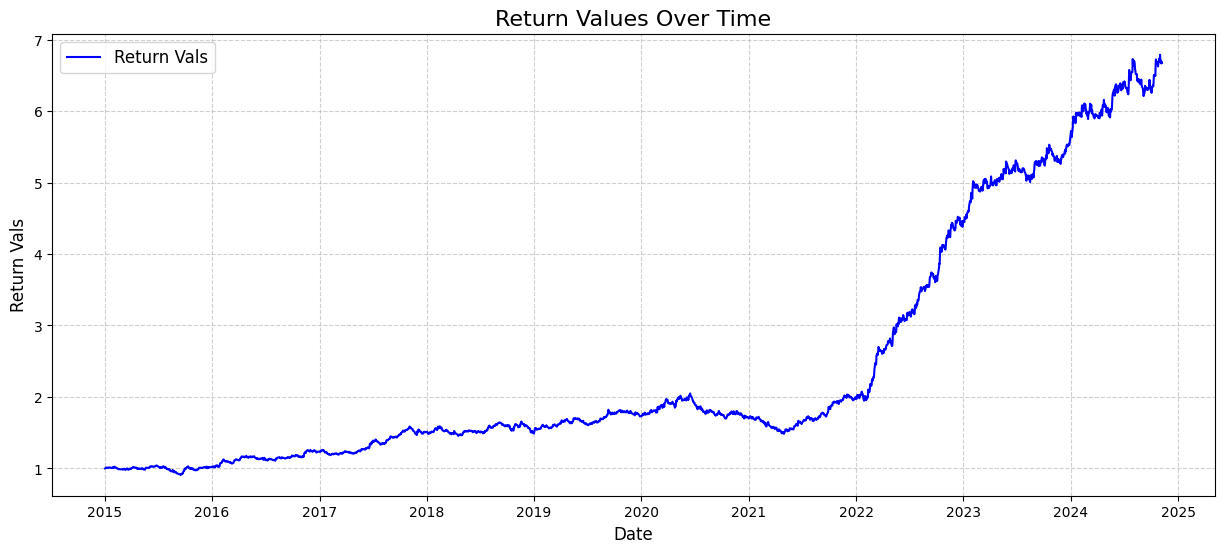

In [95]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))  # Set the figure size
plt.plot(returnDf['Date'], returnDf['ReturnVals'],  linestyle='-', color='blue', label="Return Vals")
plt.title("Return Values Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Return Vals", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.savefig("returns.png", dpi=300, bbox_inches='tight')

# Show the plot (optional)
plt.show()